In [1]:
import numpy as np
import copy
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
import scipy.stats as stats
from multiprocess import Pool
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import QuantLib as ql
import matplotlib.pyplot as plt

# Calibration for Yield Curve

We got Instanteneous Forward Rates for AAA rated bonds from ECB:
https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

And we get the initial Interest Rate from here:
https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html

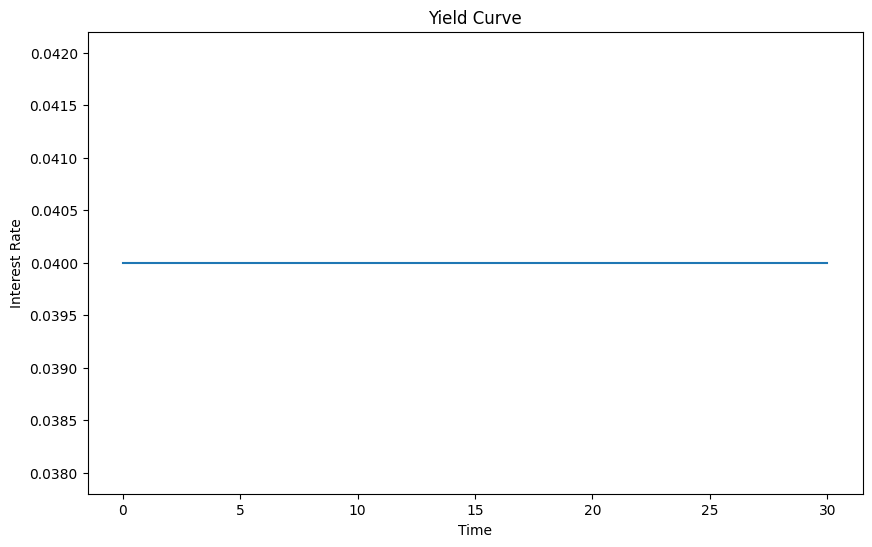

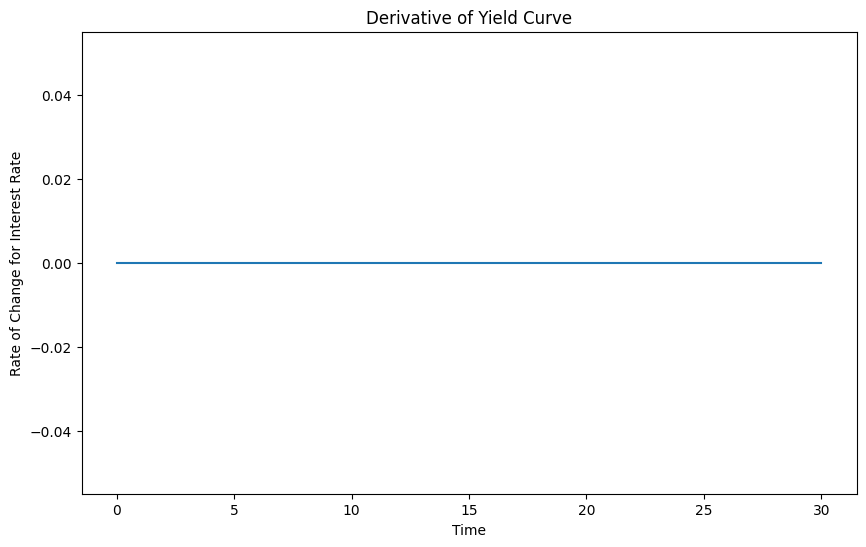

In [2]:
# Interest Rates
r0 = .04
# ECB Market Yield Curve on 7th November 2023 (Humped)
market_yields = [
    (0.25, .03708004),
    (0.50, .03480834),
    (0.75, .03205257),
    (1.0, .02944257),
    (2.0, .02342641),
    (3.0, .02264375),
    (4.0, .02372672),
    (5.0, .02519909),
    (6.0, .02661483),
    (7.0, .02786643),
    (8.0, .02894020),
    (9.0, .02984566),
    (10.0, .03059704),
    (11.0, .03120873),
    (12.0, .03169425),
    (13.0, .03206610),
    (14.0, .03233577),
    (15.0, .03251381),
    (16.0, .03260989),
    (17.0, .03263287),
    (18.0, .03259087),
    (19.0, .03249129),
    (20.0, .03234093),
    (21.0, .03214597),
    (22.0, .03191205),
    (23.0, .03164432),
    (24.0, .03134746),
    (25.0, .03102571),
    (26.0, .03068293),
    (27.0, .03032262),
    (28.0, .02994794),
    (29.0, .02956175),
    (30.0, .02916661),
]
# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
# Normal(Upward) Yield Curve
upward_yields = [
    (0.25, .041),
    (1.0, .042),
    (2.0, .043),
    (4.0, .044),
    (8.0, .0452),
    (12.0, .046),
    (24.0, .047),
    (30.0, .0471),
]
# Inverted Yield Curve
downward_yields = [
    (0.25, .039),
    (1.0, .038),
    (2.0, .037),
    (4.0, .036),
    (8.0, .0348),
    (12.0, .034),
    (24.0, .033),
    (30.0, .0329),
]

# Extract durations and yields
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

# Visualize the Fitted Curve
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields = yield_curve(maturities)   # Get the corresponding yields to maturity
plt.figure(1, figsize=(10,6))
plt.title("Yield Curve")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.plot(maturities, fitted_yields)

# Visualize the Fitted Curve dt
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields_dt = yield_curve.derivative(nu=1)(maturities)   # Get the corresponding yields to maturity
plt.figure(2, figsize=(10,6))
plt.title("Derivative of Yield Curve")
plt.xlabel("Time")
plt.ylabel("Rate of Change for Interest Rate")
plt.plot(maturities, fitted_yields_dt)

# Hull-White (One Factor Model)

Assumptions:
1. Speed of reversion is constant $\alpha$, to be obtained from current market structure
2. Volatility is constant $\sigma$, to be obtained from current market structure
3. Reversion level is time dependent, $\theta(t)$ is chosen to make the model consistent with the initial term structure, which we get from ECB yield curve.


$$
dr(t) = \alpha[\frac{\theta(t)}{\alpha}-r(t)]dt + \sigma dW(t)
$$

$$
\theta(t)=F_t(0, t)+a F(0, t)+\frac{\sigma^2}{2 a}\left(1-e^{-2 a t}\right)
$$
Where $F$ is market's instanteneous rate and $F_t$ is its derivative.


In [3]:
# Simulation's Parameters
T = 10                      # Years of Simulation
days_per_year = 365         # Days in the Year
steps = int(T*days_per_year)    # Number of steps
dt = 1.0 * T / steps            # Time step size
simulations = 1_000         # Amount of Monte Carlo runs

# Parameters for the Hull-White model
a = 0.05       # How fast is convergence to known rates. Typical Range: [0.01, 0.1]
sigma = 0.01   # Variance of rates. Typical range: [0.001, 0.02]
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
r0 = 0.04

In [4]:
# I decided not to implement vectorized explicit formula (integrals still need for loop), so I parallelyzed drift generator
# Define the function that simulates a single path
def simulate_path(params):

    _, steps, dt, r0, a, sigma, theta, yield_curve = params

    import numpy as np
    np.random.seed(_)       # So that values in each processor is unique

    theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
    Z = np.random.normal(0, 1, steps)
    dr = np.zeros(steps)
    r = np.zeros(steps)
    r[0] = r0  # Initialize with the initial rate from the market
    for t in range(1, steps):
        dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
        r[t] = r[t-1] + dr[t]
    return r

# Use multiprocess to run simulations in parallel
simulation_params = [(i, steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]

# Run in Parallel
with Pool() as pool:
    short_rate_paths = pool.map(simulate_path, simulation_params)

# Convert list of arrays to a 2D NumPy array
short_rate_paths = np.array(short_rate_paths)

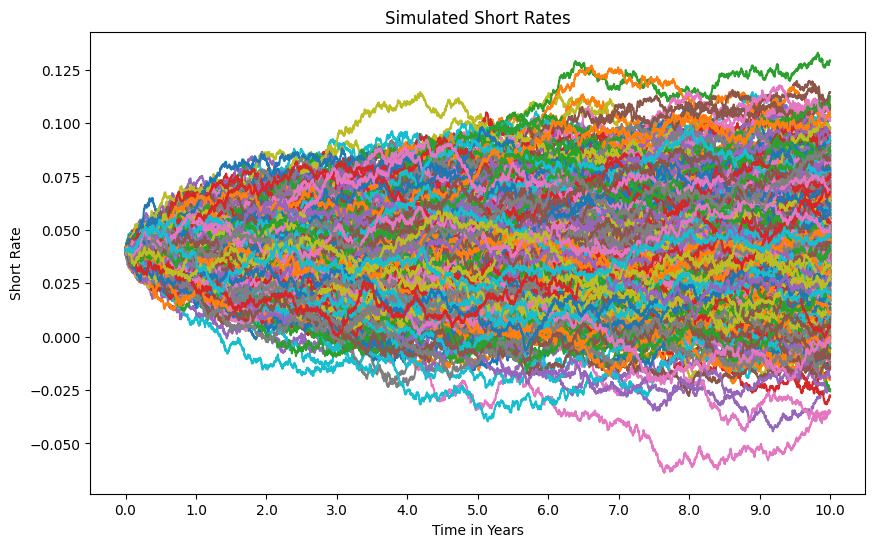

In [5]:
plt.figure(figsize=(10,6))
plt.plot(short_rate_paths.T)
plt.title("Simulated Short Rates")
locs = [x for x in np.linspace(0, T*days_per_year, int(T+1), dtype=int)]
labels = ["%.1f" %x for x in np.linspace(0, T, int(T+1))]
plt.xticks(locs, labels)
plt.xlabel("Time in Years")
plt.ylabel("Short Rate")
plt.show()

## Analytical Verification

For Hull-White model we have an analytical solution for both mean and variance of short-rates at any $t$ as observed from $t=0$. These are: 
$$
\begin{aligned}
\mathbb{E}^Q\left(r(t) \mid \mathcal{F}_0\right) & =r(0) e^{a(0-t)}+\int_0^t e^{a(u-t)} \theta(u) d u \\
\operatorname{Var}\left(r(t) \mid \mathcal{F}_0\right) &=\frac{\sigma^2}{2 a}\left(1-e^{2 a(0-t)}\right)
\end{aligned}
$$

In [6]:
# analytical_short_rates = []
# for t in np.linspace(0, T, steps):
#     integral = 0
#     for u in np.linspace(0, t, int(t*days_per_year)):
#         integral += np.exp(a*(u-t))*theta(u)*dt         # du=dt as we keep discretization step size same
#     rate_t = r0*np.exp(a*(0-t)) + integral
#     analytical_short_rates.append(rate_t)
# mean_sol = np.mean(analytical_short_rates)              # Should we add confidence interval?

# analytical_variance_rates = []
# for t in np.linspace(0, T, steps):
#     var_t = ((np.square(sigma))/(2*a)) * (1 - np.exp(2 * a * (0-t)))
#     analytical_variance_rates.append(var_t)
# variance_sol = np.mean(analytical_variance_rates)       # Should we add confidence interval?

# print("Analytical Solution for the Mean: ", mean_sol)
# print("Analytical Solution for the Variance: ", variance_sol)

In [7]:
# Some variables necessary for statistical tests
confidence_level = 0.95
d_f = simulations - 1
# T-test for the Mean
t_critical = stats.t.ppf((1 + confidence_level) / 2, d_f)
# Chi-squared test for the Variance
chi2_lower = stats.chi2.ppf((1 - confidence_level) / 2, d_f)
chi2_upper = stats.chi2.ppf((1 + confidence_level) / 2, d_f)

# Mean
sim_means = [np.mean(short_rates) for short_rates in short_rate_paths.T]    # We have to transpose, because analytical value is obtained per each time point, not per path
overall_sim_mean = np.mean(sim_means)
# Confidence Interval for the mean
mean_err = stats.sem(sim_means)  # Standard Error Mean
ci_mean = t_critical * mean_err
print("Simulation's Short Rate Mean: ", overall_sim_mean, ", with a ci: [", overall_sim_mean-ci_mean, ", ", overall_sim_mean+ci_mean, "]")

# Variance
sim_vars = [np.var(short_rates, ddof=1) for short_rates in short_rate_paths.T]    # degree_of_freedom = n-1, because it is variance
overall_sim_var = np.mean(sim_vars) + np.var(sim_vars, ddof=1)  # Variance within and between
# Confidence Interval for the variance
ci_variance_lower = (d_f * overall_sim_var) / chi2_upper
ci_variance_upper = (d_f * overall_sim_var) / chi2_lower
print("Simulation's Short Rate Variance is: ", overall_sim_var, ", with a ci: [", ci_variance_lower, ", ", ci_variance_upper, "]")

Simulation's Short Rate Mean:  0.041799440804057446 , with a ci: [ 0.04176171719929409 ,  0.0418371644088208 ]
Simulation's Short Rate Variance is:  0.0003643081148961491 , with a ci: [ 0.00033435749268165727 ,  0.00039849272852854475 ]


# Pricing Swaption

First, we must price in simpler instruments.

## Evaluating Bond

In [8]:
# Example:
s = 4.5    # For which point in time we want to find value of coupon bond (We are interested in today)
t = 7.0   # What is the maturity of coupon bond (final time)
r = 0.04   # We need to access correct short rate at time s (We assume flat curve for now)

In [9]:
def P(s, t, r, a, sigma, yield_curve):

    def A(s, t, a, sigma, yield_curve):
        term1 = (yield_curve(t)*np.exp(-r*t))/(yield_curve(s)*np.exp(-r*s))
        term2 = B(s, t, a) * yield_curve(s)
        term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
        return term1*np.exp(term2-term3)

    def B(s, t, a):
        return 1/a * (1 - np.exp(a * (s - t)))
        
    return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r)

bond_price = P(s, t, r, a, sigma, yield_curve)    # Where s is current point in time, t is future point in time, and r is short rate at s
print("Bond's price for given parameters is: ", bond_price)

Bond's price for given parameters is:  0.9039324435031081


In [10]:
# Verifying found Price

# Setup the market and yield term structure
calendar = ql.TARGET()
day_count = ql.Actual365Fixed()
todays_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = todays_date + ql.Period(int(s*12), ql.Months)

# Create a bond object
issue_date = todays_date + ql.Period(int(s*12), ql.Months)
maturity_date = todays_date + ql.Period(int(t*12), ql.Months)
bond = ql.ZeroCouponBond(0, ql.NullCalendar(), 1.0, maturity_date)

# Set up the bond engine
spot_curve_handle = ql.YieldTermStructureHandle(ql.FlatForward(issue_date, r, ql.Actual365Fixed()))
bond_engine = ql.DiscountingBondEngine(spot_curve_handle)

# Calculate the bond price
bond.setPricingEngine(bond_engine)
bond_NPV = bond.NPV()

print("QuantLib Bond price is: ", bond_NPV)

QuantLib Bond price is:  0.9046886898630425


## Pricing Swap

In [11]:
t = 3.0                 # Point in time when we are looking for contract
pay_rate = 0.5          # Semi-Annual settlement possibility, delta t_i
T_0 = 9.0               # Point in time when contract starts
T_m = 18.0              # Point in time when contract ends
fixed_rate = 0.01       # Same as Strike Rate in simple options
N = 1                   # Notional Amount
rates = np.ones(int(T_m*days_per_year))*r0   # Assume flat rates

In [12]:
def V(days_per_year, t, T_0, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve):
    term1 = P(t, T_0, rates[int(days_per_year*t)], a, sigma, yield_curve)
    term2 = P(t, T_m, rates[int(days_per_year*t)], a, sigma, yield_curve)
    term3 = 0
    for T_i in np.arange(T_0+pay_rate, T_m+pay_rate, pay_rate):       # For all intermediate and last one payout dates (np.arange does not include m)
        term3 += P(t, T_i, rates[int(days_per_year*t)], a, sigma, yield_curve) * pay_rate
    return N*(term1 - term2 - fixed_rate*term3)

# Example
swap_price = V(days_per_year, t, T_0, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve)
print("Swap's price for given parameters is: ", swap_price)

Swap's price for given parameters is:  0.18459417602459655


In [13]:
# Verifying values by running a simulation with the QuantLib (only works with flat curve)

# Setup the market and yield term structure
calendar = ql.TARGET()
day_count = ql.Actual365Fixed()
todays_date = ql.Date.todaysDate()
# Update the evaluation date
evaluation_date = todays_date + ql.Period(int(t*12), ql.Months)
ql.Settings.instance().evaluationDate = evaluation_date
flat_forward = ql.FlatForward(evaluation_date, r0, day_count)     # Flat rate curve
yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

# Swaption characteristics
# Define the fixed-rate leg
maturity_date = todays_date + ql.Period(int(T_m*12), ql.Months)
fixed_leg_tenor = ql.Period(int(pay_rate*12), ql.Months)
fixed_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, fixed_leg_tenor, calendar,
                                 ql.ModifiedFollowing, ql.ModifiedFollowing,
                                 ql.DateGeneration.Forward, False)

# Define the floating-rate leg
index = ql.IborIndex("CustomEuriborM", ql.Period(int(pay_rate*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
floating_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, index.tenor(), calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

# Create the swap
vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Payer, N, fixed_leg_schedule,
                              fixed_rate, day_count, floating_leg_schedule,
                              index, 0.0, index.dayCounter())
vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

# Calculate the NPV
swap_NPV = vanilla_swap.NPV()
print("QuantLib Swap price is: ", swap_NPV)

QuantLib Swap price is:  0.17887626741400947


## Pricing Bermudan Swaption with LSM

1. For each simulation path we need to find possible value of swap on each time period of interest.
2. Regress with LSM to find the optimal point to enter a swap.
3. Discount through time each path.
4. Find average.

### Swap value at each point of time of interest

In [14]:
# Swaption parameters
T_m = 9.0              # Maximum duration of swaption (Maturity)
pay_rate = 1.5          # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
fixed_rate = 0.06       # Strike rate
N = 1                   # Notional Amount
short_rate_paths        # Already simulated paths for short rates

array([[0.04      , 0.04020945, 0.04072172, ..., 0.00680784, 0.00662127,
        0.00688342],
       [0.04      , 0.03967979, 0.03940338, ..., 0.05338486, 0.05305676,
        0.05357709],
       [0.04      , 0.03997055, 0.03885242, ..., 0.00919182, 0.00997707,
        0.00961372],
       ...,
       [0.04      , 0.03993917, 0.04068136, ..., 0.08929282, 0.08918885,
        0.08934569],
       [0.04      , 0.04017309, 0.03949762, ..., 0.02719844, 0.02658174,
        0.02715022],
       [0.04      , 0.04073378, 0.04089847, ..., 0.048051  , 0.04769368,
        0.04759201]])

In [15]:
# Swap Values calculator
def sim_swap_eval(params):
    _, days_per_year, T_m, pay_rate, N, fixed_rate, short_rate_path, yield_curve, a, sigma = params

    import numpy as np

    # Bond Evaluation
    def P(s, t, r, a, sigma, yield_curve):

        def A(s, t, a, sigma, yield_curve):
            term1 = (yield_curve(t)*np.exp(-r*t))/(yield_curve(s)*np.exp(-r*s))
            term2 = B(s, t, a) * yield_curve(s)
            term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
            return term1*np.exp(term2-term3)

        def B(s, t, a):
            return 1/a * (1 - np.exp(a * (s - t)))
            
        return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r)
    # Swap Evaluation
    def V(days_per_year, t, T_0, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve):
        term1 = P(t, T_0, rates[int(days_per_year*t)], a, sigma, yield_curve)
        term2 = P(t, T_m, rates[int(days_per_year*t)], a, sigma, yield_curve)
        term3 = 0
        for T_i in np.arange(T_0+pay_rate, T_m+pay_rate, pay_rate):       # For all intermediate and last one payout dates (np.arange does not include m)
            term3 += P(t, T_i, rates[int(days_per_year*t)], a, sigma, yield_curve) * pay_rate
        return (N*(term1 - term2 - fixed_rate*term3))
        #return np.max([N*(term1 - term2 - fixed_rate*term3), 0])        # We only return positive swap values, because we won't exercise otherwise

    # Finding Swap Value for each possible exercise point
    swap_values = []
    for t in np.arange(0.0, T_m-pay_rate, pay_rate):     # Because of delay on starting of payments, we have less entries (Last one must be 2 pay_rates before Maturity9)
        swap_values.append(V(days_per_year, t, t+pay_rate, T_m, N, fixed_rate, pay_rate, short_rate_path, a, sigma, yield_curve))
    return (swap_values)

# Use multiprocess to run simulations in parallel
simulation_params = [(i, days_per_year, T_m, pay_rate, N, fixed_rate, short_rate_paths[i], yield_curve, a, sigma) for i in range(simulations)]
# Run in Parallel
with Pool() as pool:
    simulations_swap_values = pool.map(sim_swap_eval, simulation_params)

# Same but one threaded
# simulations_swap_values = []
# for i in range(simulations):
#     simulation_params = [i, days_per_year, T_m, pay_rate, N, fixed_rate, short_rate_paths[i], yield_curve, a, sigma]
#     simulations_swap_values.append(sim_swap_eval(simulation_params))

# Convert list of arrays to a 2D NumPy array
simulations_swap_values = np.array(simulations_swap_values)

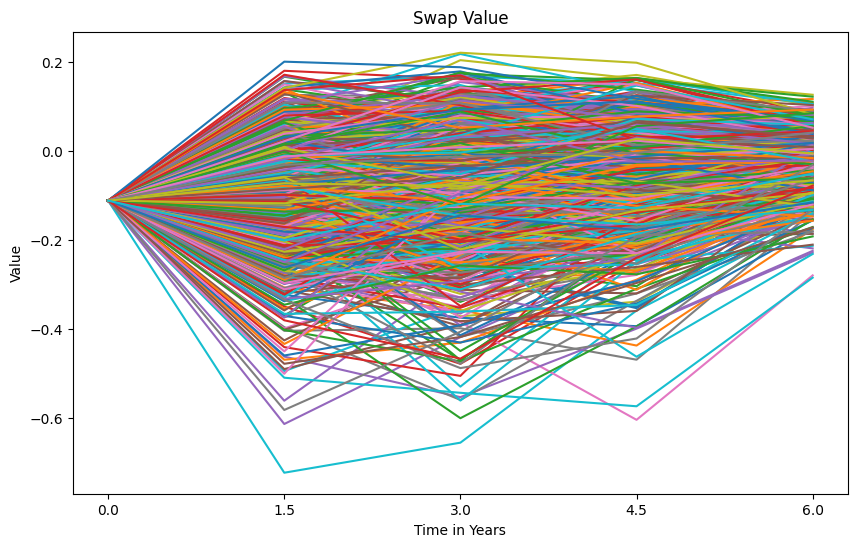

In [16]:
# Plotting paths that have meaning
plt.figure(figsize=(10,6))
plt.plot(simulations_swap_values.T)
plt.title("Swap Value")
labels = ["%.1f" %x for x in np.linspace(0, T_m-(2*pay_rate), len(simulations_swap_values[1]))]
locs = [x for x in np.linspace(0, len(simulations_swap_values[1])-1, len(simulations_swap_values[1]), dtype=int)]
plt.xticks(locs, labels)
plt.xlabel("Time in Years")
plt.ylabel("Value")
plt.show()

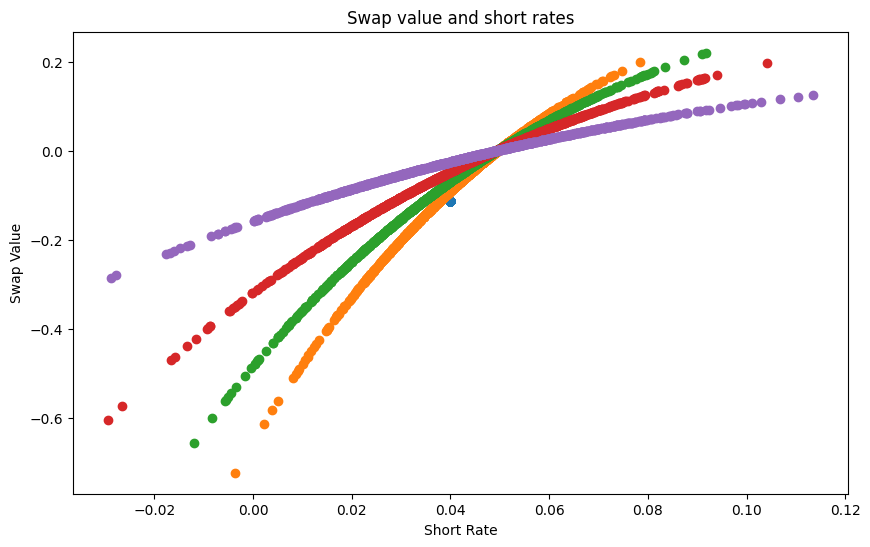

In [17]:
# We should also create the same with the prediction of continuation value instead of actual swap value
plt.figure(figsize=(10,6))
plt.title("Swap value and short rates")
plt.xlabel("Short Rate")
plt.ylabel("Swap Value")

for k in range(len(simulations_swap_values.T)):
    plt.scatter(short_rate_paths.T[int(k*pay_rate*days_per_year)], simulations_swap_values.T[k])

### Finding best exercise point and price for each path

In [18]:
# # Finding forward rates based on the simulated short rates
# forward_rate_paths_regression = []
# for simulation in range(simulations):
#     forward_rates_temp = []
#     for t in np.arange(0.0, T_m-pay_rate, pay_rate):
#         # To be clear what is counted where, made variables as explicit as possible
#         start_id = int(days_per_year*t)
#         finish_id = int(days_per_year*(t+pay_rate))
#         forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates
#         forward_rates_temp.append(forward_rate)
#     forward_rate_paths_regression.append(forward_rates_temp)
# forward_rate_paths_regression = np.array(forward_rate_paths_regression)         # r_s for Regression

# # Regressing and Finding optimal points to enter swap with fair value
# simulations_swap_values_reg = copy.deepcopy(simulations_swap_values)        # So we do not have to rerun pricing of swaps
# for i in reversed(range(0, simulations_swap_values_reg.shape[1]-1)):
#     ids_to_fit = np.where(simulations_swap_values_reg[:, i] > 0)[0]        # Creating mask to regress only "in money" options
#     if np.any(ids_to_fit):
#         # Getting continuation Values
#         Y = simulations_swap_values_reg[ids_to_fit, i+1].reshape(-1,1) * np.exp(-forward_rate_paths_regression[ids_to_fit, i].reshape(-1,1) * pay_rate)
#         X_pred = short_rate_paths[ids_to_fit, i].reshape(-1,1)
#         # Linear Model
#         model = LinearRegression().fit(X_pred, Y)                               # For now it is just 1d linear regression, should try polynomial and more time entries to improve accuracy
#         continuation_values = model.predict(short_rate_paths[ids_to_fit, i].reshape(-1,1))

#         for j in range(len(continuation_values)):
#             #print(continuation_values[j], " vs ", simulations_swap_values_reg[ids_to_fit[j], i])
#             if continuation_values[j] > simulations_swap_values_reg[ids_to_fit[j], i]:
#                 simulations_swap_values_reg[ids_to_fit[j],i] = 0.0
#             else: simulations_swap_values_reg[ids_to_fit[j],i+1:] = 0.0

# print(simulations_swap_values_reg)

In [19]:
# # Arrays to hold values of best exercise periods
# max_indexes = []
# max_values = []
# sim_id = []

# fair_values_t = []
# for sim in range(simulations):
#     max_index = np.argmax(simulations_swap_values_reg[sim])
#     max_value = simulations_swap_values_reg[sim][max_index]

#     # Used for later visualization
#     if (max_value > 0):
#         sim_id.append(sim)
#         max_indexes.append(max_index)
#         max_values.append(max_value)

#     disc_rate = np.sum(forward_rate_paths_regression[sim, :max_index+1])
#     max_value_fair = max_value*np.exp(-disc_rate)        # dt cancels with days per year, obviously
#     fair_values_t.append(max_value_fair)
# print(fair_values_t)
# fair_value_t = np.mean(fair_values_t)
# print("Bermudan Swaption Fair Value is: ", fair_value_t)
# print("Simple Swap's price for the same set of parameters is: ", V(days_per_year, 0.0, pay_rate, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve))

Discounted Expected Cashflow
 [0.00000000e+00 4.38015877e-02 0.00000000e+00 0.00000000e+00
 1.75699593e-02 0.00000000e+00 3.26833800e-02 0.00000000e+00
 5.29398796e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.28251467e-02 5.75498371e-02 4.27212779e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.75856807e-03 0.00000000e+00 3.58654314e-03
 0.00000000e+00 4.59451399e-02 4.12878554e-02 0.00000000e+00
 0.00000000e+00 1.09584769e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.26829312e-02 0.00000000e+00
 5.71853646e-02 0.00000000e+00 5.55074583e-02 2.47127024e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.57033046e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.10728821e-03 0.00000000e+00 0.00000000e+00 4.83578945e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.1286866

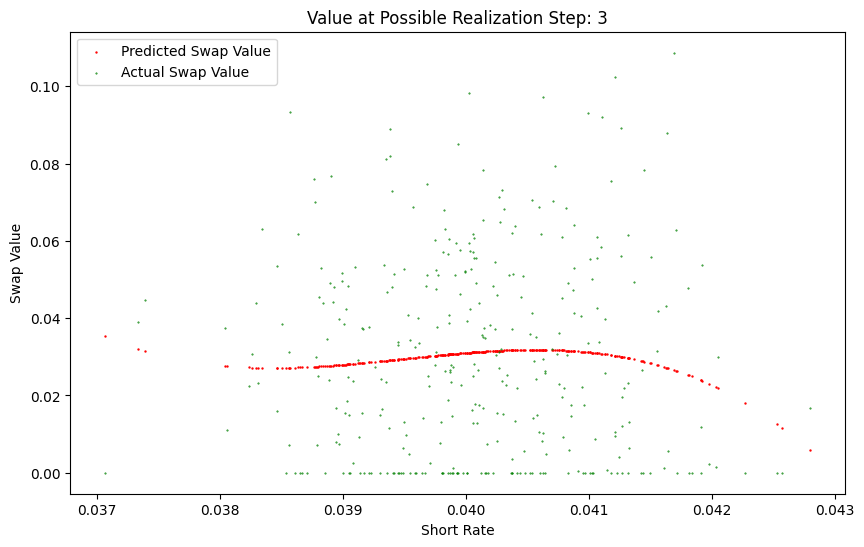

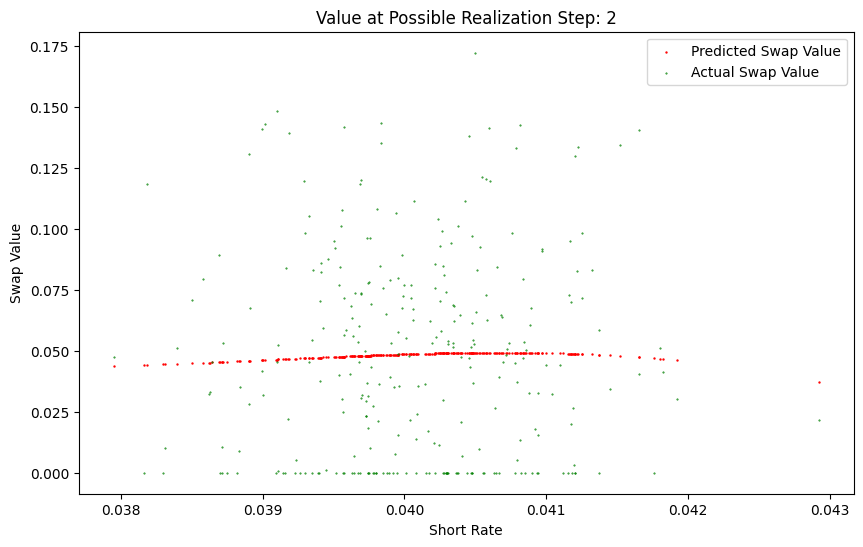

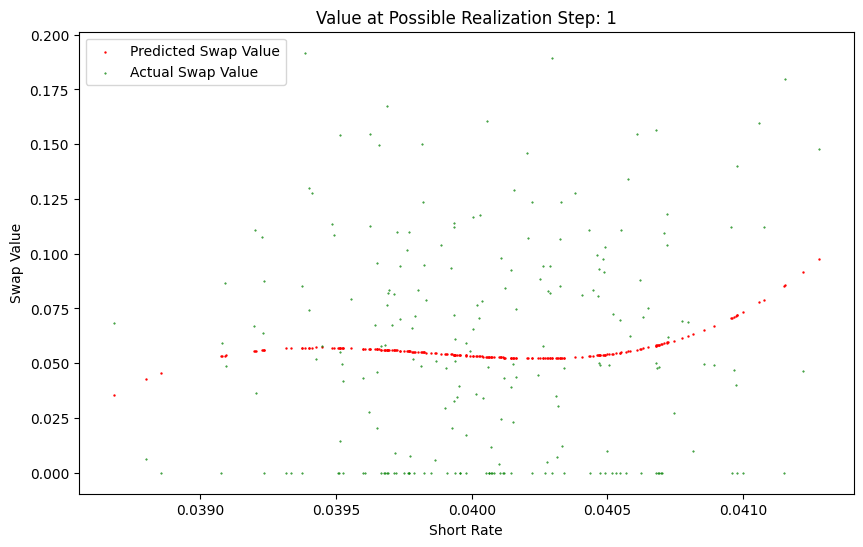

Realization Matrix
[[0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0

In [20]:
np.set_printoptions(threshold=100000)       # To show detailed arrays

# Finding forward rates based on the simulated short rates
forward_rate_paths_regression = []
for simulation in range(simulations):
    forward_rates_temp = []
    for t in np.arange(0.0, T_m-pay_rate, pay_rate):
        # To be clear what is counted where, made variables as explicit as possible
        start_id = int(days_per_year*t)
        finish_id = int(days_per_year*(t+pay_rate))
        forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates for correct time period
        forward_rates_temp.append(forward_rate)
    forward_rate_paths_regression.append(forward_rates_temp)
forward_rate_paths_regression = np.array(forward_rate_paths_regression)         # discounting value for each period between tenors

# Independent Variable for Regression (For first step it is just a discounted value of swap at the maturity (Discounted Realized Cashflow))
expected_cashflow = simulations_swap_values[:, -1] * np.exp(-forward_rate_paths_regression[:, -1])
expected_cashflow[np.where(simulations_swap_values[:, -1] < 0)] = 0.0      # If swap is not In Money, we just let it expire
print("Discounted Expected Cashflow\n", expected_cashflow)

# Matrix of points where we exercise
realization_matrix = np.zeros(simulations_swap_values.shape)
realization_matrix[np.where(simulations_swap_values[:, -1] > 0), -1] = 1.0      # At last point we exercise if in money
print("Realization Matrix\n", realization_matrix)

for i in range(simulations_swap_values.shape[1]-2, 0, -1):              # Starting from the back
    ids_to_fit = np.where(simulations_swap_values[:, i] > 0)[0]         # Creating mask to regress only "in money" swaps
    if np.any(ids_to_fit):
        # Getting continuation Values
        Y = expected_cashflow[ids_to_fit].reshape(-1,1)             # It is already discounted
        X_pred = short_rate_paths[ids_to_fit, i].reshape(-1,1)      # Dependent variable is our short rate

        # Fit the Linear Regression model to the polynomial features
        poly = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly.fit_transform(X_pred)
        model = LinearRegression().fit(X_poly, Y)
        # Predict using the polynomial features
        continuation_values = model.predict(poly.transform(short_rate_paths[ids_to_fit, i].reshape(-1,1)))

        # Visualization of Regression
        plt.figure(figsize=(10,6))
        plt.title("Value at Possible Realization Step: " + str(i))
        plt.xlabel("Short Rate")
        plt.ylabel("Swap Value")
        plt.scatter(short_rate_paths[ids_to_fit, i], continuation_values, c="red", label="Predicted Swap Value", s=0.5)
        plt.scatter(short_rate_paths[ids_to_fit, i], expected_cashflow[ids_to_fit], c="green", label="Actual Swap Value", s=0.2)
        plt.legend()
        plt.show()

    # Creating independent variable for the next iteration
    expected_cashflow_temp = np.zeros(simulations)
    for k in range(simulations):   # For each path we should find out if it is better to exercise or not
        if k in ids_to_fit:             # If there is any update to value during regression
            if simulations_swap_values[k, i] > continuation_values[np.where(ids_to_fit==k)] and simulations_swap_values[k, i] > 0:
                expected_cashflow_temp[k] = simulations_swap_values[k, i] * np.exp(-forward_rate_paths_regression[k, i])        # We exercise and keep this value
                realization_matrix[k,i] = 1.0           # For future reference
                realization_matrix[k,i+1:] = 0.0        # Delete all older subsequent realizations, we keep only the earliest
            else:                       # keep the value same otherwise, discounted
                expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i])
        else:                           # keep the value same otherwise, discounted
            expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i])
    expected_cashflow = expected_cashflow_temp

print("Realization Matrix")
print(realization_matrix)
print("Swap Values")
print(simulations_swap_values)

### Finding fair value of swaption

In [21]:
# Arrays to hold values of best exercise periods
max_indexes = []
max_values = []
sim_id = []

fair_values_t = []
for sim in range(simulations):
    # Finding max value in array
    max_index = np.argmax(realization_matrix[sim])
    max_value = simulations_swap_values[sim][max_index]

    # If path was never exercized, i.e. its value is less than zero, we just let it expire worthless
    if (max_value > 0):
        # Used for later visualization
        sim_id.append(sim)
        max_indexes.append(max_index)
        max_values.append(max_value)

        # Discounting swaps values at optimal execution points
        disc_rate = np.sum(forward_rate_paths_regression[sim, :max_index])
        max_value_fair = max_value*np.exp(-disc_rate)
        fair_values_t.append(max_value_fair)

fair_value_t = np.sum(fair_values_t)/simulations
print("Bermudan Swaption Fair Value is: ", fair_value_t)

# Calculating EU swapption value for comparison
eu_option = []
for i in range(simulations):
    value_at_decision = V(days_per_year, pay_rate, 2*pay_rate, T_m, N, fixed_rate, pay_rate, short_rate_paths[i], a, sigma, yield_curve)
    if value_at_decision < 0: value_at_decision = 0       # If negative, we just do not exercise
    eu_option.append(value_at_decision*np.exp(forward_rate_paths_regression[simulation, 0]))
print("European Swaption Fair Value is: ", np.mean(eu_option))

print("Simple Swap's price for the same set of parameters is: ", V(days_per_year, 0.0, pay_rate, T_m, N, fixed_rate, pay_rate, rates, a, sigma, yield_curve))

Bermudan Swaption Fair Value is:  0.02489721679173255
European Swaption Fair Value is:  0.012834036852410904
Simple Swap's price for the same set of parameters is:  -0.11116996752207797


In [22]:
# Nah, this thing is not working properly, and it is not worth to make it work, we need to create the binomial tree pricer by ourselves
# Verifying values by running a simulation with the QuantLib (only works with flat curve)

# Setup the market and yield term structure
calendar = ql.TARGET()
day_count = ql.Actual365Fixed()
todays_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = todays_date
flat_forward = ql.FlatForward(todays_date, r0, day_count)     # Flat rate curve
yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

# Swaption characteristics
# Define the fixed-rate leg
start_date = todays_date
maturity_date = start_date + ql.Period(int(T_m*12), ql.Months)
fixed_leg_tenor = ql.Period(int(pay_rate*12), ql.Months)
fixed_leg_schedule = ql.Schedule(start_date+ql.Period(int(pay_rate*12), ql.Months), maturity_date, fixed_leg_tenor, calendar,
                                 ql.ModifiedFollowing, ql.ModifiedFollowing,
                                 ql.DateGeneration.Forward, False)

# Define the floating-rate leg
index = ql.IborIndex("CustomEuriborM", ql.Period(int(pay_rate*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
floating_leg_schedule = ql.Schedule(start_date+ql.Period(int(pay_rate*12), ql.Months), maturity_date, index.tenor(), calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

# Define the swaption
hull_white_model = ql.HullWhite(yield_curve_handle, a, sigma)
exercise_dates = [date for date in fixed_leg_schedule]
exercise = ql.BermudanExercise(exercise_dates, False)
swaption = ql.Swaption(ql.VanillaSwap(ql.VanillaSwap.Payer, N, fixed_leg_schedule,
                                      fixed_rate, day_count, floating_leg_schedule,
                                      index, 0.0, index.dayCounter()), exercise)
# Setup the pricing engine
engine = ql.TreeSwaptionEngine(hull_white_model, 100)
swaption.setPricingEngine(engine)
npv = swaption.NPV()
print("QuantLib Bermudan Swaption price is: ", npv)


# Define the European swaption
exercise = ql.EuropeanExercise(start_date+ql.Period(int(pay_rate*12), ql.Months))
european_swaption = ql.Swaption(ql.VanillaSwap(ql.VanillaSwap.Payer, N, fixed_leg_schedule,
                                      fixed_rate, day_count, floating_leg_schedule,
                                      index, 0.0, index.dayCounter()), exercise)

# Setup the pricing engine for European swaption
european_swaption.setPricingEngine(engine)
european_swaption_npv = european_swaption.NPV()
print("QuantLib European Swaption price is: ", european_swaption_npv)


# Define the Simple Swap
vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Payer, N, fixed_leg_schedule,
                              fixed_rate, day_count, floating_leg_schedule,
                              index, 0.0, index.dayCounter())
vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

# Calculate the NPV
swap_NPV = vanilla_swap.NPV()
print("QuantLib Swap price is: ", swap_NPV)

QuantLib Bermudan Swaption price is:  0.007860583868892731
QuantLib European Swaption price is:  0.0009972672906444454
QuantLib Swap price is:  -0.11134635197403586


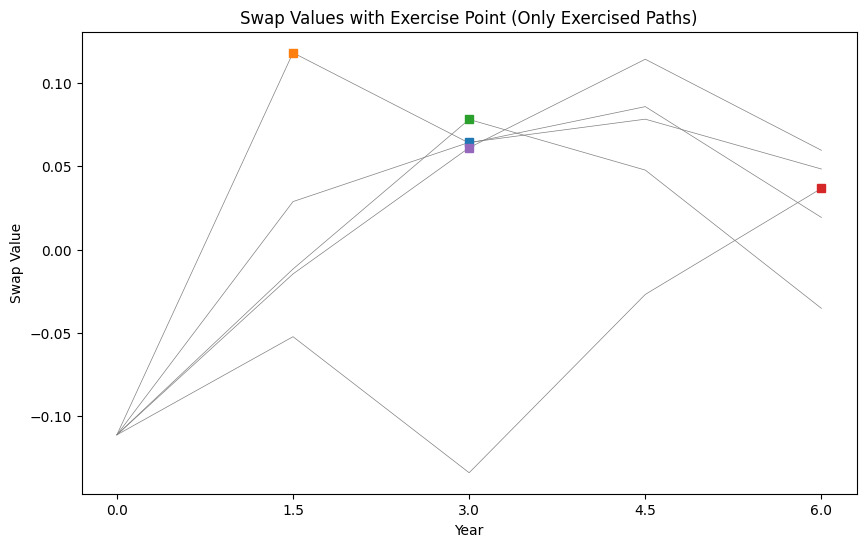

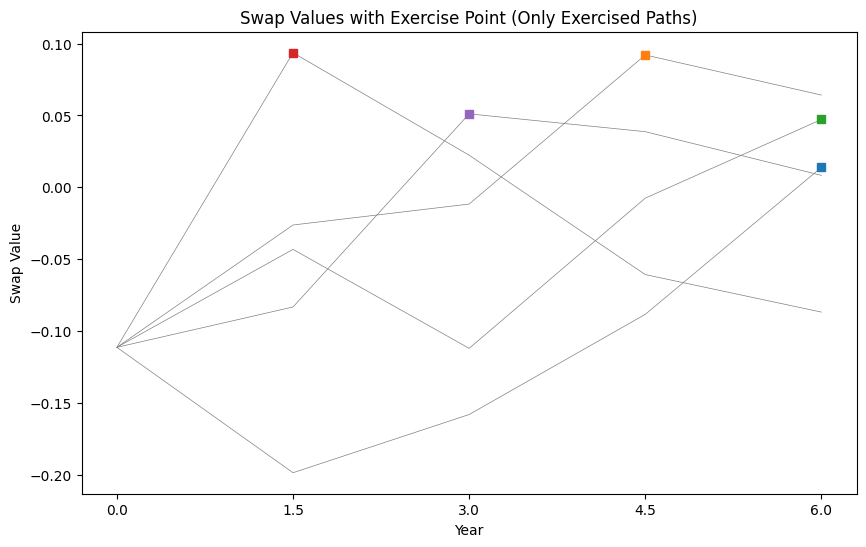

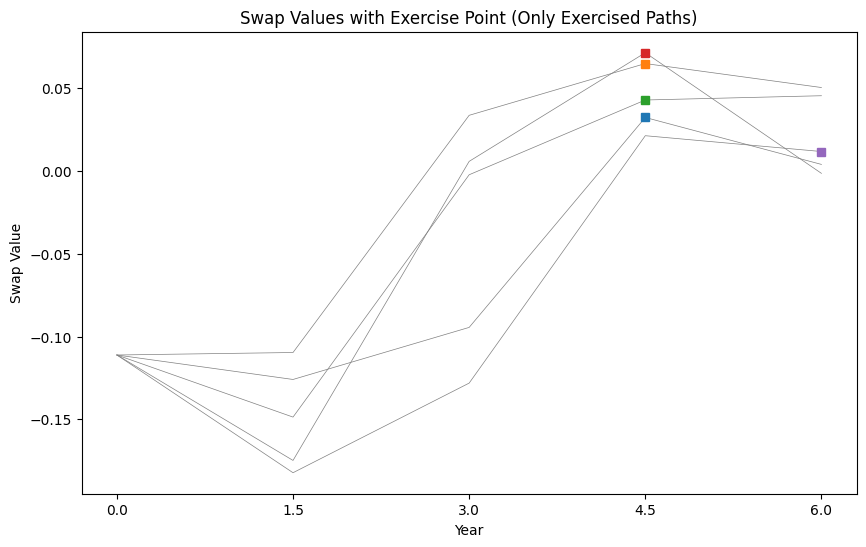

In [25]:
k=-1
for pic in range(3):
    plt.figure(k, figsize=(10,6))
    #for id in range(len(sim_id)):
    for id in range(5):
        k+=1
        plt.plot(simulations_swap_values[sim_id[k]], "grey", zorder=1, linewidth = '0.5')               # Draw k-th swap value path
        plt.plot(max_indexes[k], simulations_swap_values[sim_id[k]][max_indexes[k]], "s", zorder=2)     # Show exercise point
    plt.title("Swap Values with Exercise Point (Only Exercised Paths)")
    plt.xlabel("Year")
    plt.ylabel("Swap Value")

    labels = ["%.1f" %x for x in np.linspace(0, T_m-2*pay_rate, int((T_m-2*pay_rate)/pay_rate)+1)]
    locs = [x for x in range(len(labels))]
    plt.xticks(locs, labels)

    plt.show()

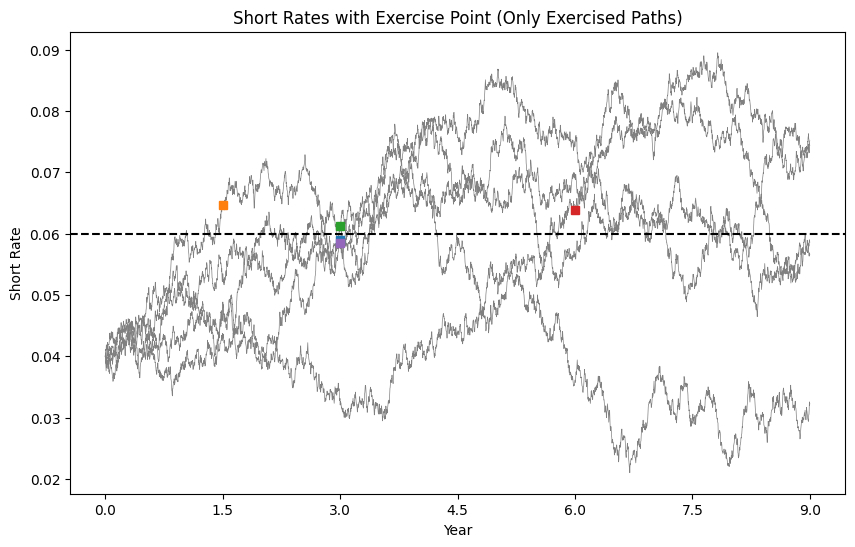

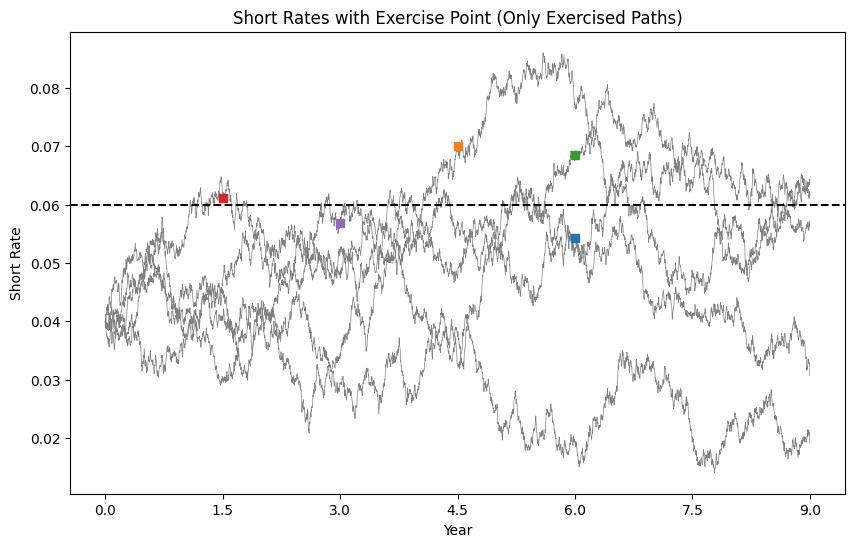

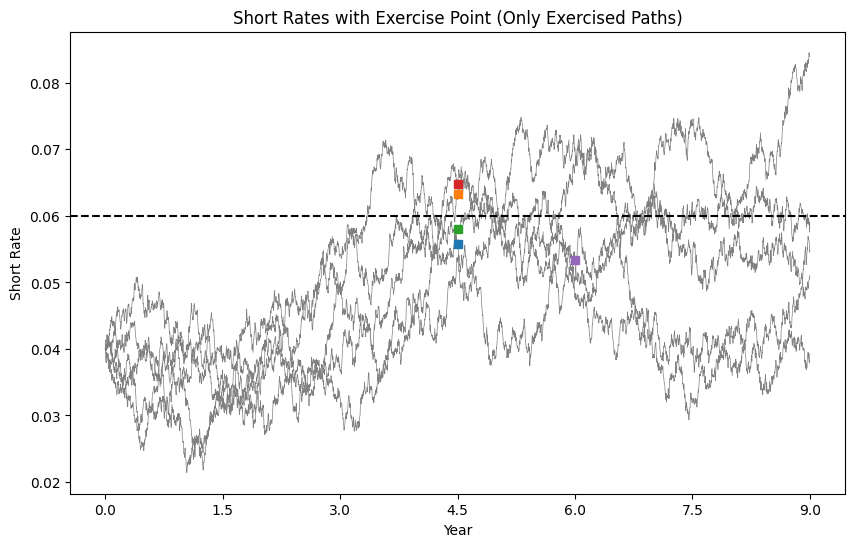

In [26]:
k=-1
for pic in range(3):
    plt.figure(k, figsize=(10,6))
    #for id in range(len(sim_id)):
    for id in range(5):
        k+=1
        finish_day_sim = int(T_m*days_per_year)
        plt.plot(short_rate_paths[sim_id[k]][:finish_day_sim].T, "grey", zorder=1, linewidth = '0.5')       # Draw k-th short rate path
        day_point_sim = int(max_indexes[k]*pay_rate*days_per_year)
        plt.plot(day_point_sim, short_rate_paths[sim_id[k]][day_point_sim], "s", zorder=2)

    plt.axhline(y = fixed_rate, color = 'black', linestyle = '--', zorder=3) 
    labels = ["%.1f" %x for x in np.linspace(0, T_m, int(T_m/pay_rate)+1)]
    locs = [x for x in np.linspace(0, T_m*days_per_year, int(T_m/pay_rate)+1, dtype=int)]
    plt.title("Short Rates with Exercise Point (Only Exercised Paths)")
    plt.xticks(locs, labels)
    plt.xlabel("Year")
    plt.ylabel("Short Rate")
    plt.show()